In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.varmax import VARMAX
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product


# 10.3 실질 가처분 소득과 실질 소비 예측

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


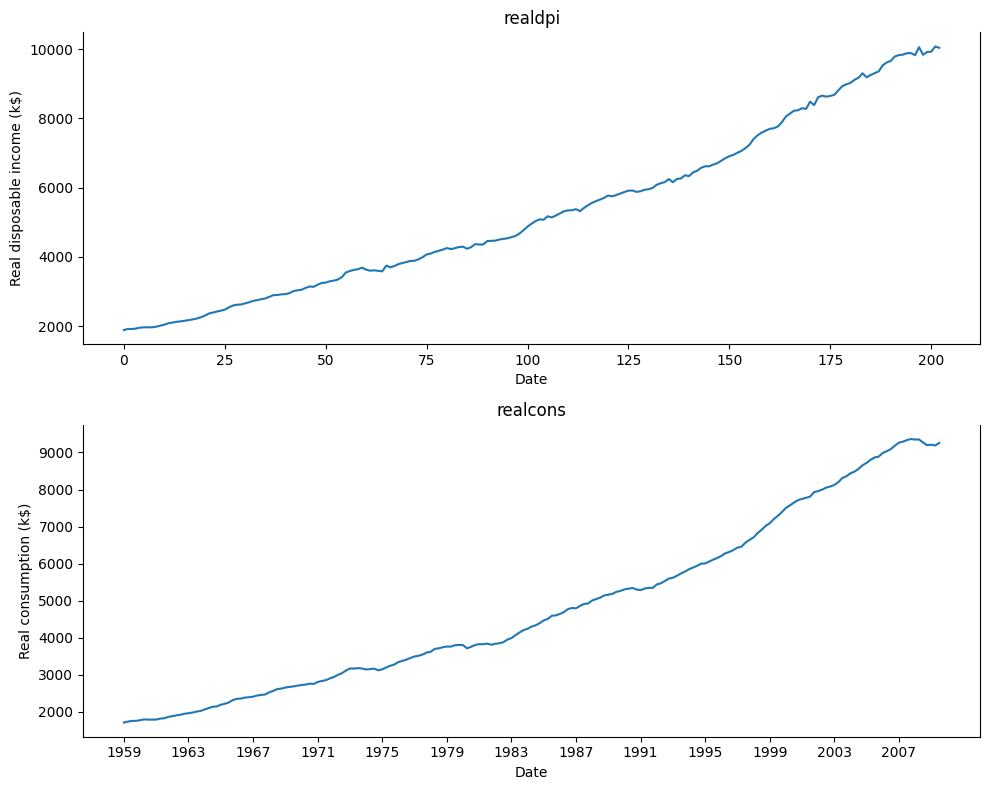

In [3]:
# 도식화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)

plt.xticks(np.arange(0,208,16), np.arange(1959,2010,4))

plt.tight_layout()
plt.show()

In [4]:
# ADF 테스트
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])
print('realdpi')
print(f'ADF Statistic : {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n----------------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic : {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic : 2.9860253519546855
p-value: 1.0

----------------------------

realcons
ADF Statistic : 1.5499123380509592
p-value: 0.9976992503412904


In [5]:
# 시계열 차분 후 다시 정상성 테스트
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi')
print(f'ADF Statistic : {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n----------------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic : {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic : -8.864893340673007
p-value: 1.4493606159108096e-14

----------------------------

realcons
ADF Statistic : -4.204306080845245
p-value: 0.0006479282158627595


In [6]:
# 많은 VAR(p) 모델을 피팅하고 가장 낮은 AIC를 가진 모델을 선택하는 함수

def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:

  results = []

  for i in tqdm(range(15)):
    try:
      model = VARMAX(endog, order=(i,0)).fit(dips=False)
    except:
      continue

    aic = model.aic
    results.append([i, aic])

  result_df = pd.DataFrame(results)
  result_df.columns = ['p', 'AIC']

  result_df = result_df.sort_values(by='AIC',
                                    ascending=True).reset_index(drop=True)

  return result_df

In [7]:
# 훈련집합과 테스트집합 정의 (8:2)
endog = macro_econ_data[['realdpi', 'realcons']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,AIC
0,3,3123.070078
1,5,3123.708523
2,6,3126.855594
3,4,3129.194045
4,2,3130.091668
5,7,3133.398329
6,1,3134.333343
7,8,3137.149017
8,9,3140.367179
9,10,3147.839017


In [8]:
# 그레인저 인과관계 테스트

print('realcons Granger-causes realdpi?\n')
print('----------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('----------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])


realcons Granger-causes realdpi?

----------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

----------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


In [9]:
# 잔차 분석 위해 훈련 집합에 VAR(3) 모델 피팅
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

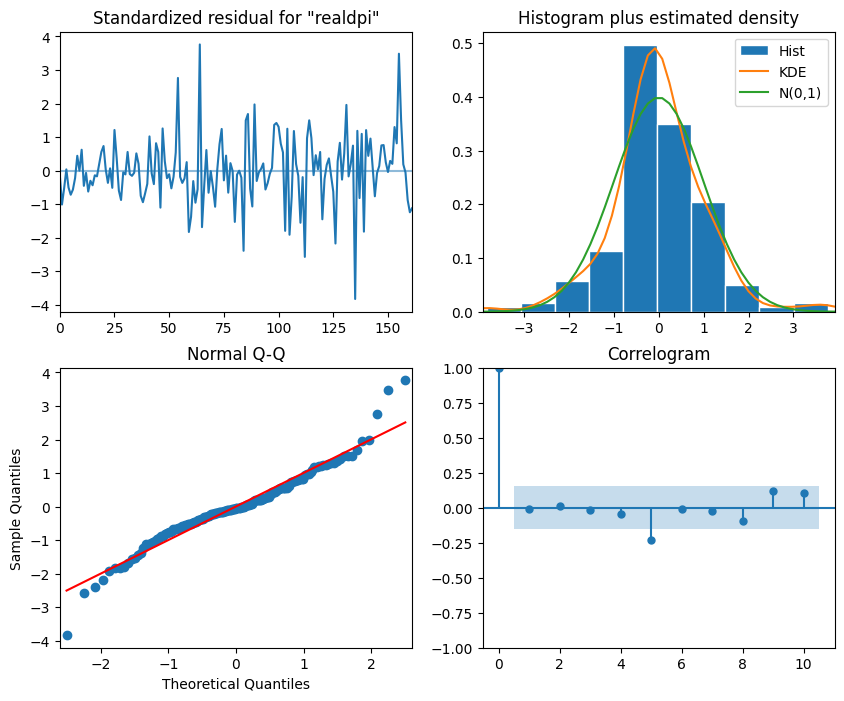

In [10]:
# realdpi 잔차
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

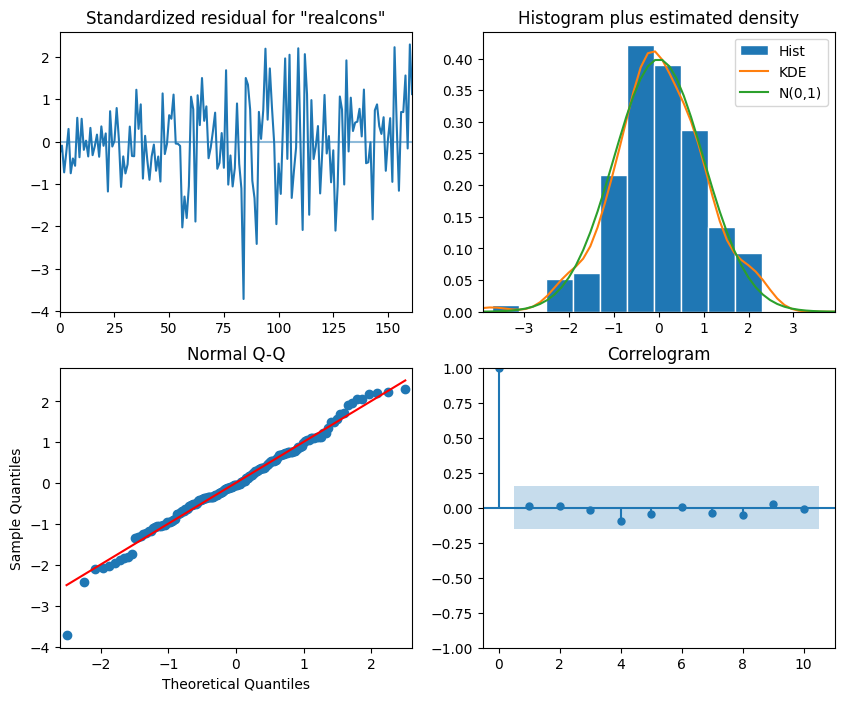

In [11]:
# realcons 잔차
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

In [12]:
# 융-박스 테스트
realgdp_residuals = best_model_fit.resid['realdpi']

pvalue = acorr_ljungbox(realgdp_residuals, lags=np.arange(1, 11, 1), return_df=True)

print(pvalue['lb_pvalue'].to_numpy())

[0.91418132 0.98543347 0.9945775  0.98424539 0.10350646 0.16448121
 0.23382931 0.21259277 0.14872327 0.12192164]


In [13]:
realcons_residuals = best_model_fit.resid['realcons']

pvalue = acorr_ljungbox(realcons_residuals, lags=np.arange(1, 11, 1), return_df=True)

print(pvalue['lb_pvalue'].to_numpy())

[0.87705024 0.96628181 0.99531067 0.9935814  0.99592098 0.99240812
 0.99457696 0.97604187 0.98252234 0.99168105]


In [14]:
# 롤링예측하는 함수
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

  total_len = train_len + horizon
  end_idx = train_len

  if method == 'VAR':

    realdpi_pred_VAR = []
    realcons_pred_VAR = []

    for i in range(train_len, total_len, window):
      model = VARMAX(df[:i], order=(3,0))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)

      oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
      oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']

      realdpi_pred_VAR.append(oos_pred_realdpi)
      realcons_pred_VAR.append(oos_pred_realcons)

    return realdpi_pred_VAR, realcons_pred_VAR

  elif method == 'last':
    realdpi_pred_last = []
    realcons_pred_last = []

    for i in range(train_len, total_len, window):

      realdpi_last = df[:i].iloc[-1]['realdpi']
      realcons_last = df[:i].iloc[-1]['realcons']

      realdpi_pred_last.extend(realdpi_last for _ in range(window))
      realcons_pred_last.extend(realcons_last for _ in range(window))

    return realdpi_pred_last, realcons_pred_last


In [15]:
# rolling_forecast함수와 VAR(3)모델을 사용하여 realdpi와 realcons에 대한 예측 생성
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR, = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

test = endog[163:]

test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)

test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)


In [16]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.224428,7354.326427,7716.0,7199.9
164,8053.4,7501.3,7897.188835,7430.258328,7716.0,7199.9
165,8135.9,7571.8,7960.563090,7496.633231,7716.0,7199.9
166,8222.3,7645.9,8014.757171,7556.620350,7716.0,7199.9
167,8234.6,7713.5,8080.703201,7631.003694,8135.9,7571.8
168,8296.5,7744.3,8142.392741,7692.851966,8135.9,7571.8
169,8273.7,7773.5,8200.123307,7753.871530,8135.9,7571.8
170,8484.5,7807.7,8259.362062,7812.539778,8135.9,7571.8
171,8385.5,7930.0,8264.386051,7864.640383,8273.7,7773.5
172,8611.6,7957.3,8320.858388,7895.065138,8273.7,7773.5


In [17]:
# MAPE 계산
def mape(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

print(f'realdpi MAPE (VAR): {mape_realdpi_VAR:.2f}%')
print(f'realdpi MAPE (last): {mape_realdpi_last:.2f}%')
print(f'realcons MAPE (VAR): {mape_realcons_VAR:.2f}%')
print(f'realcons MAPE (last): {mape_realcons_last:.2f}%')



realdpi MAPE (VAR): 3.14%
realdpi MAPE (last): 2.26%
realcons MAPE (VAR): 1.77%
realcons MAPE (last): 2.46%


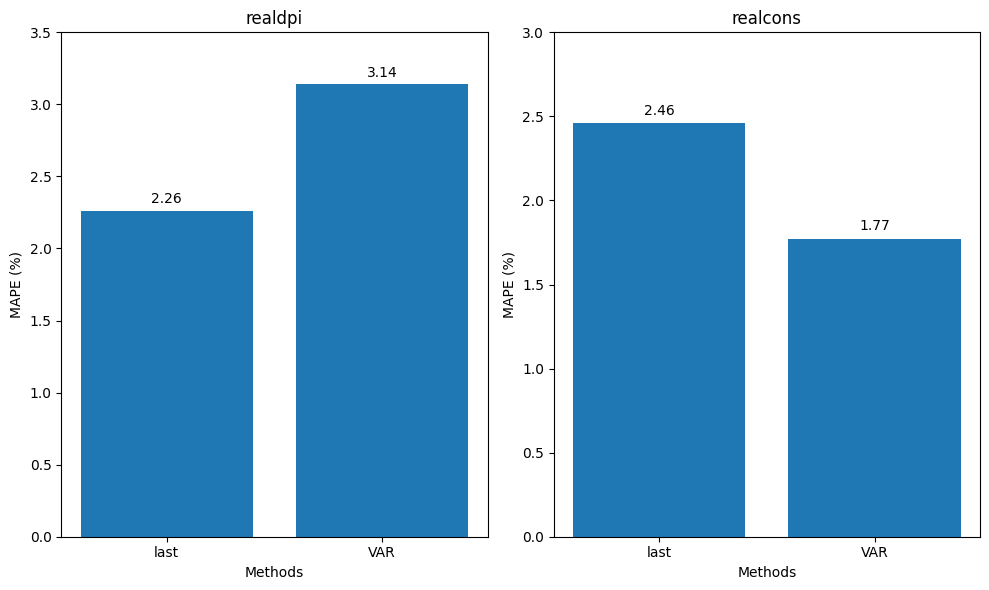

In [18]:
# MAPE 도식화

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR']
y1 = [mape_realdpi_last, mape_realdpi_VAR]
y2 = [mape_realcons_last, mape_realcons_VAR]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()


#10.5 연습

## 10.5.1 VARMA 모델 사용하여 realdpi와 realcons 예측

###1. 같은 훈련 집합 및 테스트 집합 사용

In [19]:
endog = macro_econ_data[['realdpi', 'realcons']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]


###2. 고유한 (p,q) 조합의 목록 생성

In [20]:
p = range(0,4,1)
q = range(0,4,1)

###3.optimaze_VARMA, 모든 고유한 (p,q) 조합에 대해 반복하도록 수정

In [21]:
def optimize_VARMA(endog, parameters_list) -> pd.DataFrame:

  results = []

  for i in tqdm(parameters_list):
    try:
      model = VARMAX(endog, order=(i)).fit(dips=False)
    except:
      continue

    aic = model.aic
    results.append([i, aic])

  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,q)', 'AIC']

  result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

  return result_df

###4. AIC가 가장 낮은 모델을 선택하고 그레인저 인과관계 테스트 수행, (p,q) 조합 중 가장 큰 순서로 통과

In [22]:
parameter_list = list(product(p,q))

result_df_VARMA = optimize_VARMA(train, parameter_list)
result_df_VARMA

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 0)",3123.070078
1,"(2, 1)",3124.096814
2,"(1, 3)",3125.157568
3,"(3, 2)",3125.511651
4,"(2, 3)",3125.787497
5,"(1, 2)",3126.994290
6,"(3, 1)",3129.020409
7,"(1, 1)",3129.183456
8,"(2, 2)",3129.938078
9,"(2, 0)",3130.091668


In [23]:
# 그레인저 인과관계 테스트

print('realcons Granger-causes realdpi?\n')
print('----------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('----------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])


realcons Granger-causes realdpi?

----------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

----------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


모두 p가 0.05보다 작기 때문에 귀무가설 기각 -> 모델이 유효함을 알 수 있다.

### 5. 잔차분석 수행

In [24]:
# 잔차 분석 위해 훈련 집합에 VARMA(3,0) 모델 피팅
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

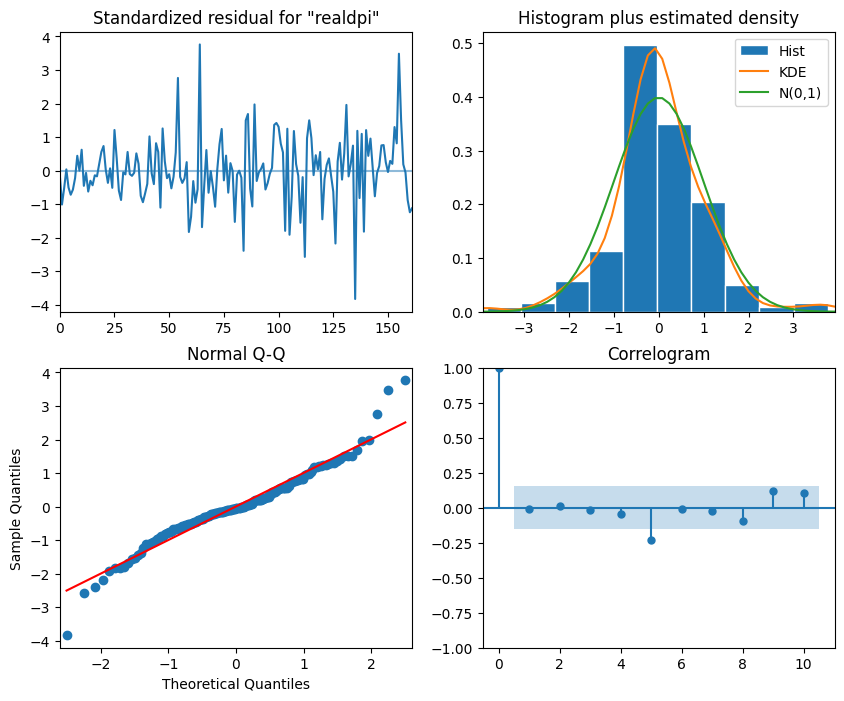

In [25]:
# realdpi 잔차
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

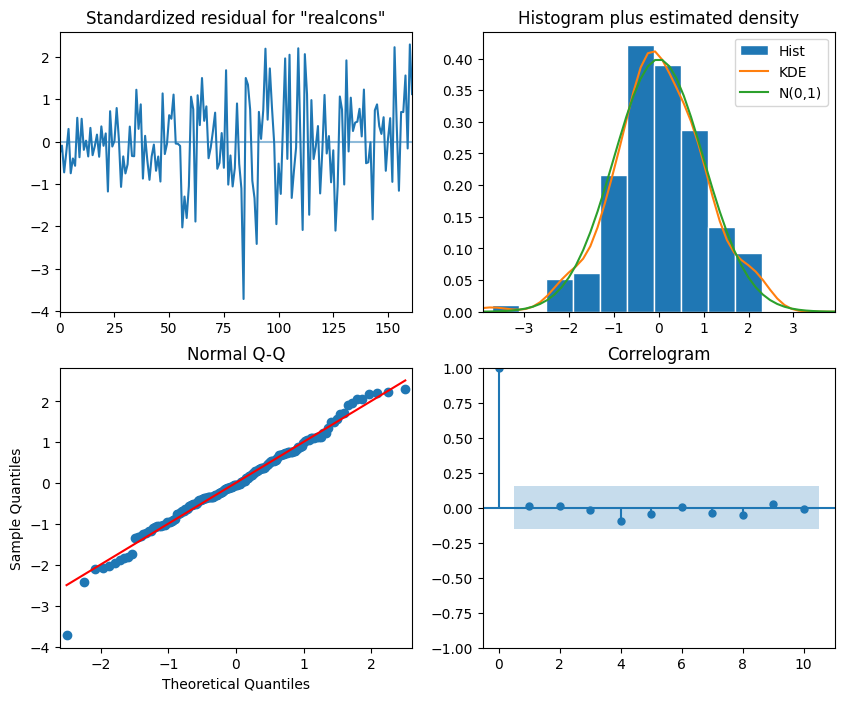

In [26]:
# realcons 잔차
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

In [27]:
# 융-박스 테스트
realgdp_residuals = best_model_fit.resid['realdpi']

pvalue = acorr_ljungbox(realgdp_residuals, lags=np.arange(1, 11, 1), return_df=True)

print(pvalue['lb_pvalue'].to_numpy())

[0.91418132 0.98543347 0.9945775  0.98424539 0.10350646 0.16448121
 0.23382931 0.21259277 0.14872327 0.12192164]


In [28]:
realcons_residuals = best_model_fit.resid['realcons']

pvalue = acorr_ljungbox(realcons_residuals, lags=np.arange(1, 11, 1), return_df=True)

print(pvalue['lb_pvalue'].to_numpy())

[0.87705024 0.96628181 0.99531067 0.9935814  0.99592098 0.99240812
 0.99457696 0.97604187 0.98252234 0.99168105]


###6. 테스트집합에 대해 4단계 윈도우에서 예측 수행, 마지막으로 측정된 값 방법을 베이스라인 모델로 사용

In [29]:
# 롤링예측하는 함수
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

  total_len = train_len + horizon
  end_idx = train_len

  if method == 'VARMA':

    realdpi_pred_VARMA = []
    realcons_pred_VARMA = []

    for i in range(train_len, total_len, window):
      model = VARMAX(df[:i], order=(3,0))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)

      oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
      oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']

      realdpi_pred_VARMA.append(oos_pred_realdpi)
      realcons_pred_VARMA.append(oos_pred_realcons)

    return realdpi_pred_VARMA, realcons_pred_VARMA

  elif method == 'last':
    realdpi_pred_last = []
    realcons_pred_last = []

    for i in range(train_len, total_len, window):

      realdpi_last = df[:i].iloc[-1]['realdpi']
      realcons_last = df[:i].iloc[-1]['realcons']

      realdpi_pred_last.extend(realdpi_last for _ in range(window))
      realcons_pred_last.extend(realcons_last for _ in range(window))

    return realdpi_pred_last, realcons_pred_last


In [30]:
# rolling_forecast함수와 VARMA(3,0)모델을 사용하여 realdpi와 realcons에 대한 예측 생성
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VARMA, realcons_pred_VARMA, = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMA')

test = endog[163:]

test['realdpi_pred_VARMA'] = pd.Series()
test['realdpi_pred_VARMA'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VARMA)

test['realcons_pred_VARMA'] = pd.Series()
test['realcons_pred_VARMA'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VARMA)

In [31]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

,realdpi,realcons,realdpi_pred_VARMA,realcons_pred_VARMA,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.224428,7354.326427,7716.0,7199.9
164,8053.4,7501.3,7897.188835,7430.258328,7716.0,7199.9
165,8135.9,7571.8,7960.563090,7496.633231,7716.0,7199.9
166,8222.3,7645.9,8014.757171,7556.620350,7716.0,7199.9
167,8234.6,7713.5,8080.703201,7631.003694,8135.9,7571.8
168,8296.5,7744.3,8142.392741,7692.851966,8135.9,7571.8
169,8273.7,7773.5,8200.123307,7753.871530,8135.9,7571.8
170,8484.5,7807.7,8259.362062,7812.539778,8135.9,7571.8
171,8385.5,7930.0,8264.386051,7864.640383,8273.7,7773.5
172,8611.6,7957.3,8320.858388,7895.065138,8273.7,7773.5


### 7. MAPE 계산, VAR(3) 모델과 베이스라인 모델 중 어느 것이 낮은지 비교

In [32]:
# MAPE 계산
def mape(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_realdpi_VARMA = mape(test['realdpi'], test['realdpi_pred_VARMA'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VARMA = mape(test['realcons'], test['realcons_pred_VARMA'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

print(f'realdpi MAPE (VARMA): {mape_realdpi_VARMA:.2f}%')
print(f'realdpi MAPE (VAR): {mape_realdpi_VAR:.2f}%')
print(f'realdpi MAPE (last): {mape_realdpi_last:.2f}%')
print(f'realcons MAPE (VARMA): {mape_realcons_VARMA:.2f}%')
print(f'realcons MAPE (VAR): {mape_realcons_VAR:.2f}%')
print(f'realcons MAPE (last): {mape_realcons_last:.2f}%')



realdpi MAPE (VARMA): 3.14%
realdpi MAPE (VAR): 3.14%
realdpi MAPE (last): 2.26%
realcons MAPE (VARMA): 1.77%
realcons MAPE (VAR): 1.77%
realcons MAPE (last): 2.46%


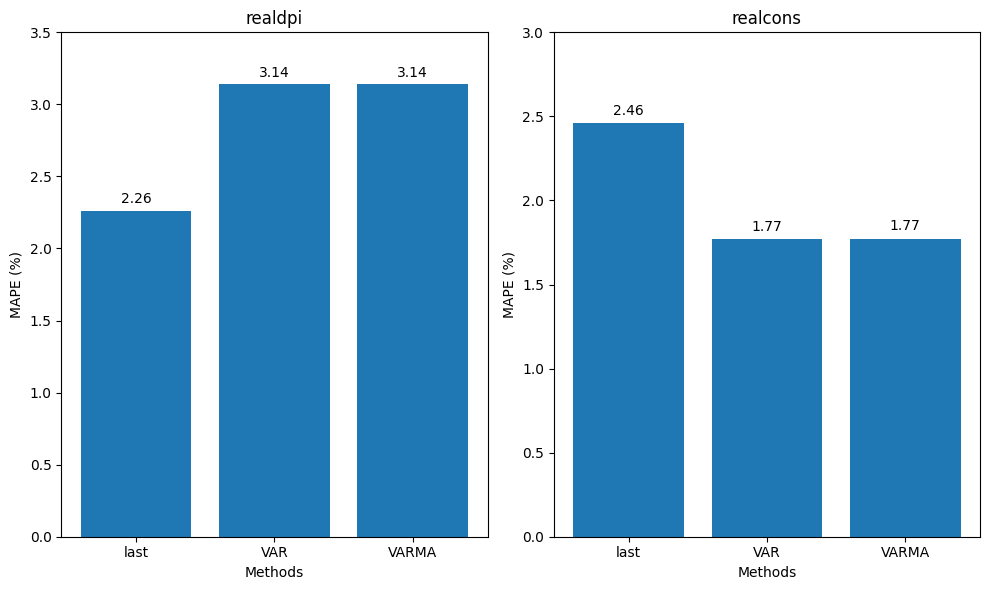

In [33]:
# MAPE 도식화

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR', 'VARMA']
y1 = [mape_realdpi_last, 3.14, mape_realdpi_VARMA] # 기존 var(3)값 넣어주기
y2 = [mape_realcons_last, 1.77, mape_realcons_VARMA]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()


VAR과 VARMA 둘 다 (p,q)가 (3,0)이므로 결과가 똑같은 것을 확인할 수 있음.

## 10.5.2 VARMAX 모델 사용하여 realdpi와 realcons 예측

###1. 같은 훈련 집합 및 테스트 집합 사용

In [34]:
endog = macro_econ_data[['realdpi', 'realcons']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]


###2. 고유한 (p,q) 조합의 목록 생성

In [35]:
p = range(0,4,1)
q = range(0,4,1)

###3.optimaze_VARMAX, 모든 고유한 (p,q) 조합과 외생 변수에 대해 반복하도록 수정

In [36]:
def optimize_VARMAX(endog, exog, parameters_list) -> pd.DataFrame:

  results = []

  for i in tqdm(parameters_list):
    try:
      model = VARMAX(endog, exog, order=(i)).fit(dips=False)
    except:
      continue

    aic = model.aic
    results.append([i, aic])

  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,q)', 'AIC']

  result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

  return result_df

###4. AIC가 가장 낮은 모델을 선택하고 그레인저 인과관계 테스트 수행, (p,q) 조합 중 가장 큰 순서로 통과

In [37]:
exog_cols = macro_econ_data.columns.drop(['year', 'quarter', 'realdpi', 'realcons'])
exog = macro_econ_data[exog_cols][1:163]

parameter_list = list(product(p,q))

result_df_VARMAX = optimize_VARMAX(train, exog, parameter_list)
result_df_VARMAX

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 0)",3113.465986
1,"(2, 0)",3117.855528
2,"(1, 1)",3119.158963
3,"(0, 1)",3120.096864
4,"(3, 0)",3121.521262
5,"(0, 3)",3122.398470
6,"(0, 2)",3123.637209
7,"(1, 2)",3125.051543
8,"(2, 1)",3125.652015
9,"(1, 3)",3126.776470


In [38]:
# 그레인저 인과관계 테스트

print('realcons Granger-causes realdpi?\n')
print('----------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [1])

print('\nrealdpi Granger-causes realcons?\n')
print('----------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [1])


realcons Granger-causes realdpi?

----------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=35.3881 , p=0.0000  , df=1
likelihood ratio test: chi2=32.5962 , p=0.0000  , df=1
parameter F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1

realdpi Granger-causes realcons?

----------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=7.8540  , p=0.0051  , df=1
likelihood ratio test: chi2=7.7045  , p=0.0055  , df=1
parameter F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1


모두 p가 0.05보다 작기 때문에 귀무가설 기각 -> 모델이 유효함을 알 수 있다.

###5. 잔차분석 수행

In [39]:
# 잔차 분석 위해 훈련 집합에 VARMAX(1,0) 모델 피팅
best_model = VARMAX(train, exog, order=(1,0))
best_model_fit = best_model.fit(disp=False)

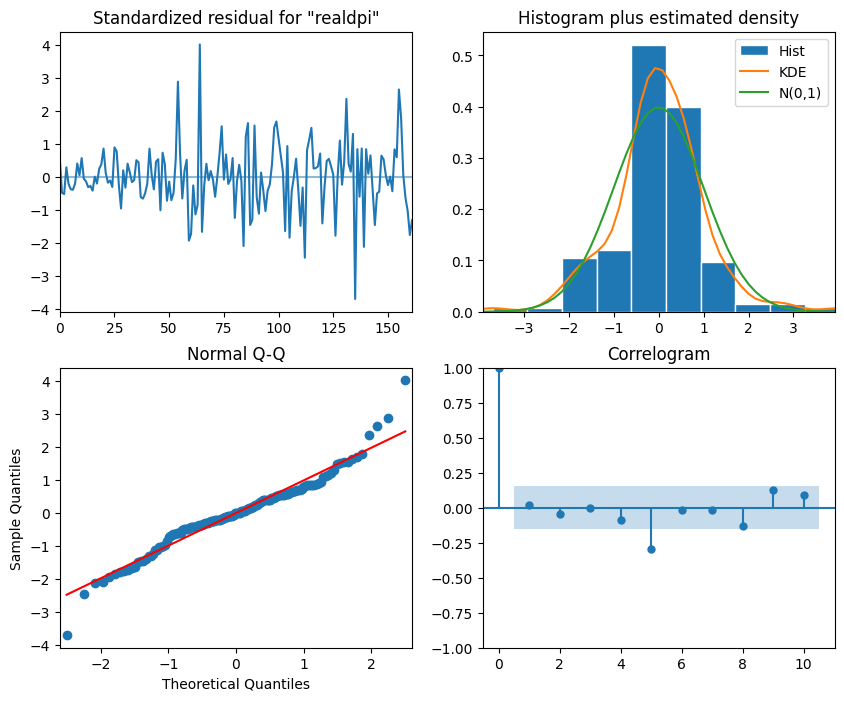

In [40]:
# realdpi 잔차
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

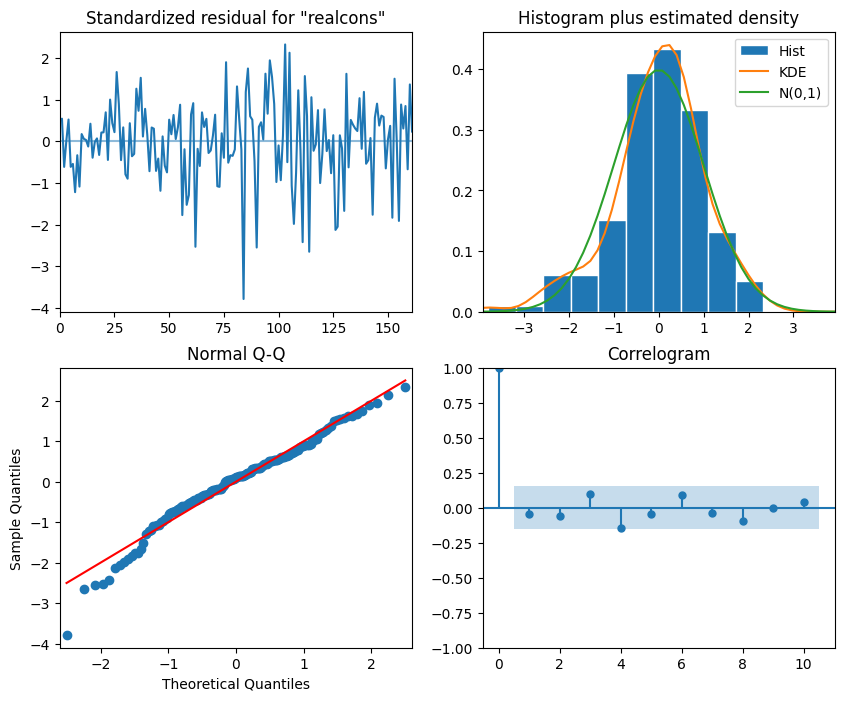

In [41]:
# realcons 잔차
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

In [42]:
# 융-박스 테스트
realgdp_residuals = best_model_fit.resid['realdpi']

pvalue = acorr_ljungbox(realgdp_residuals, lags=np.arange(1, 11, 1), return_df=True)

print(pvalue['lb_pvalue'].to_numpy())

[0.78345758 0.81383598 0.93762289 0.77387233 0.00624224 0.01229584
 0.02228861 0.01346435 0.00890878 0.00908354]


In [43]:
realcons_residuals = best_model_fit.resid['realcons']

pvalue = acorr_ljungbox(realcons_residuals, lags=np.arange(1, 11, 1), return_df=True)

print(pvalue['lb_pvalue'].to_numpy())

[0.60534142 0.36410459 0.0774313  0.04790152 0.0476822  0.0371703
 0.05685491 0.02144478 0.03550637 0.05132076]


###6. 테스트집합에 대해 한 단계 윈도우에서 예측 수행, 마지막으로 측정된 값 방법을 베이스라인 모델로 사용

In [44]:
# 롤링예측하는 함수
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

  total_len = train_len + horizon
  end_idx = train_len

  if method == 'VARMAX':

    realdpi_pred_VARMAX = []
    realcons_pred_VARMAX = []

    for i in range(train_len, total_len, window):
      model = VARMAX(df[:i], exog[:i], order=(1,0))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1, exog=exog.iloc[-1])

      oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
      oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']

      realdpi_pred_VARMAX.append(oos_pred_realdpi)
      realcons_pred_VARMAX.append(oos_pred_realcons)

    return realdpi_pred_VARMAX, realcons_pred_VARMAX

  elif method == 'last':
    realdpi_pred_last = []
    realcons_pred_last = []

    for i in range(train_len, total_len, window):

      realdpi_last = df[:i].iloc[-1]['realdpi']
      realcons_last = df[:i].iloc[-1]['realcons']

      realdpi_pred_last.extend(realdpi_last for _ in range(window))
      realcons_pred_last.extend(realcons_last for _ in range(window))

    return realdpi_pred_last, realcons_pred_last


In [45]:
# rolling_forecast함수와 VARMAX(1,0)모델을 사용하여 realdpi와 realcons에 대한 예측 생성
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

exog = macro_econ_data[exog_cols][1:]

realdpi_pred_VARMAX, realcons_pred_VARMAX = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMAX')

test = endog[163:]

test['realdpi_pred_VARMAX'] = pd.Series()
test['realdpi_pred_VARMAX'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VARMAX)

test['realcons_pred_VARMAX'] = pd.Series()
test['realcons_pred_VARMAX'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VARMAX)

In [46]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

,realdpi,realcons,realdpi_pred_VARMAX,realcons_pred_VARMAX,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7798.394721,7412.381405,7716.0,7199.9
164,8053.4,7501.3,7827.110519,7544.829705,7765.9,7286.4
165,8135.9,7571.8,7866.416346,7682.001675,7887.7,7389.2
166,8222.3,7645.9,7907.802853,7809.056992,8053.4,7501.3
167,8234.6,7713.5,7947.318385,7930.848319,8135.9,7571.8
168,8296.5,7744.3,7991.894361,8042.646251,8222.3,7645.9
169,8273.7,7773.5,8013.801617,8156.495197,8234.6,7713.5
170,8484.5,7807.7,8036.414217,8249.252784,8296.5,7744.3
171,8385.5,7930.0,8038.501027,8350.921528,8273.7,7773.5
172,8611.6,7957.3,8086.539365,8437.973146,8484.5,7807.7


### 7. MAPE 계산, 모델이 베이스라인 모델보다 더 나은 성능을 보이는지 비교

In [47]:
mape_realdpi_VARMAX = mape(test['realdpi'], test['realdpi_pred_VARMAX'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VARMAX = mape(test['realcons'], test['realcons_pred_VARMAX'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

print(f'realdpi MAPE (VARMAX): {mape_realdpi_VARMAX:.2f}%')
print(f'realdpi MAPE (last): {mape_realdpi_last:.2f}%')
print(f'realcons MAPE (VARMAX): {mape_realcons_VARMAX:.2f}%')
print(f'realcons MAPE (last): {mape_realcons_last:.2f}%')



realdpi MAPE (VARMAX): 10.72%
realdpi MAPE (last): 1.43%
realcons MAPE (VARMAX): 4.82%
realcons MAPE (last): 1.37%


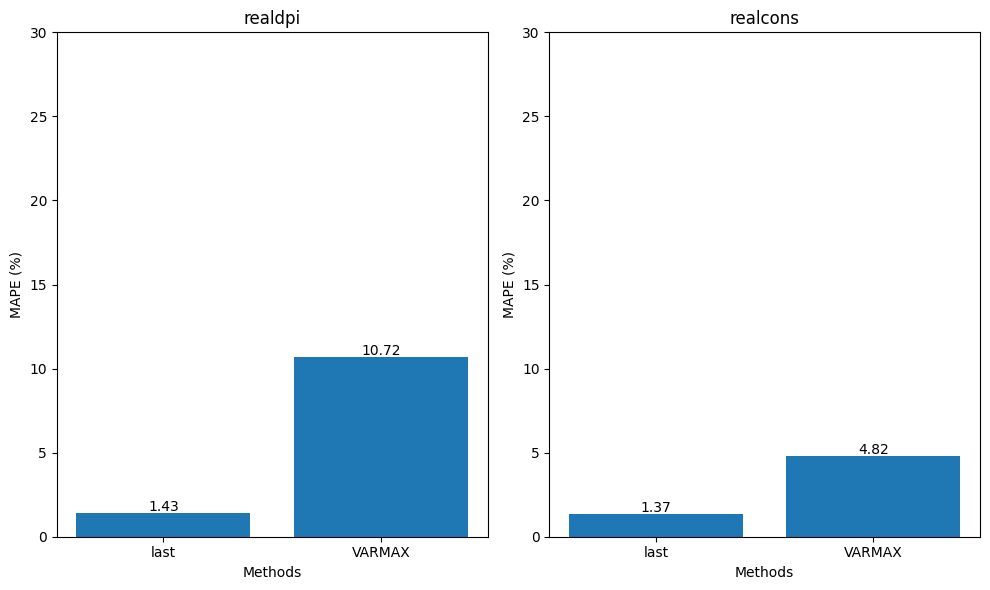

In [48]:
# MAPE 도식화

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VARMAX']
y1 = [mape_realdpi_last, mape_realdpi_VARMAX]
y2 = [mape_realcons_last, mape_realcons_VARMAX]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 30)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 30)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')

for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')

plt.tight_layout()
